In [2]:
import os
import numpy as np
import pandas as pd
import torch 
from glob import glob
from natsort import natsorted
from torch.utils.data import Dataset , DataLoader

import nibabel as nib
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
import random

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [3]:
# !nvidia-smi

In [4]:
torch.cuda.empty_cache()

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu' )
device

device(type='cpu')

In [6]:
data_dir = r'G:\BraTS'

Train_data = natsorted(glob( os.path.join(data_dir, r"MICCAI_BraTS2020_TrainingData","*")))
Val_data = natsorted(glob( os.path.join(data_dir, r"MICCAI_BraTS2020_ValidationData","*")))
test_data = natsorted(glob(os.path.join(r"G:\BraTS\MICCAI_BraTS2020_TestingData" , "*")))

test_data


['G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_357',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_358',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_359',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_360',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_361',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_362',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_363',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_364',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_365',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_366',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_367',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_368',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_369']

In [7]:
len(test_data)

15

In [8]:
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
# torch.cuda.empty_cache()

# About the data we have 

All BraTS multimodal scans are available as NIfTI files (.nii.gz) 

-> commonly used medical imaging format to store brain imagin data obtained using MRI and describe different MRI settings

T1: T1-weighted, native image, sagittal or axial 2D acquisitions, with 1–6 mm slice thickness.

T1c: T1-weighted, contrast-enhanced (Gadolinium) image, with 3D acquisition and 1 mm isotropic voxel size for most patients.

T2: T2-weighted image, axial 2D acquisition, with 2–6 mm slice thickness.

FLAIR: T2-weighted FLAIR image, axial, coronal, or sagittal 2D acquisitions, 2–6 mm slice thickness.

Data were acquired with different clinical protocols and various scanners from multiple (n=19) institutions.

All the imaging datasets have been segmented manually, by one to four raters, following the same annotation protocol, and their annotations were approved by experienced neuro-radiologists. 

Annotations comprise the GD-enhancing tumor (ET — label 4), the peritumoral edema (ED — label 2), and the necrotic and non-enhancing tumor core (NCR/NET — label 1), as described both in the BraTS 2012-2013 TMI paper and in the latest BraTS summarizing paper.

The provided data are distributed after their pre-processing, i.e., co-registered to the same anatomical template, interpolated to the same resolution (1 mm^3) and skull-stripped.

so basically data contains 4 nii files , each file consist of multiple but equivalent split regarding the corresponding data folder.

the intensity of the MRI scan can be from -1000 to +3000 so we need a scaler to scale the images from 0 to 1 .



# **select data to check**

In [9]:
test_folder = test_data[0]


all_file_paths = glob(os.path.join(test_folder, "*"))



print(all_file_paths)
print(f"First folder: {all_file_paths[0]}")



['G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_flair.nii', 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_seg.nii', 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t1.nii', 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t1ce.nii', 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t2.nii']
First folder: G:\BraTS\MICCAI_BraTS2020_TestingData\BraTS20_Training_355\BraTS20_Training_355_flair.nii


In [10]:
len(all_file_paths)

5

# **Check the file data**

In [11]:

# # check the file data ......
test_image_flair = nib.load(all_file_paths[0]).get_fdata()

test_mask = nib.load(all_file_paths[1]).get_fdata()

test_image_t1 = nib.load(all_file_paths[2]).get_fdata()

test_image_t1ce = nib.load(all_file_paths[3]).get_fdata()

test_image_t2 = nib.load(all_file_paths[4]).get_fdata()

print(test_image_flair.max()) # we can see how the big the intensity is ......



1854.603271484375


# scale the data between 0 and 1 

In [12]:
# test_image_flair.shape

In [13]:
# we know that the data cant be scaled in a 3D visual format or volume or something like this...
# the data can be scaled if its flatten , so we need to reshape it first....


# so will flatten it first

# test_image_flair.reshape(-1,test_image_flair.shape[-1]).shape

# then we will scale it usign scaler

In [14]:

test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1 , test_image_flair.shape[-1])).reshape(test_image_flair.shape)

test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1 , test_image_t1.shape[-1])).reshape(test_image_t1.shape)

test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1 , test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1 , test_image_t2.shape[-1])).reshape(test_image_t2.shape)

test_mask = test_mask.astype(np.uint8) # dont scale it 

In [15]:
test_mask.max()


4

# **Now we need to remove the label 3 and replace label 4 with label 3**

why so ??

the values of labels are as follows for the data set

Label 0 = unlabbeled volume , means there is no label regarding this area 

Label 1 = Ncrotic and non-enhancing tumor core (NCR/NET) , the core part where the tumor is .

Label 2 = pertumoral edema (ED)

Label 3 = Missing ( no pixels in all the volume contains label 3 )

Label 4 =  GD-enhancing tumor (ET)

since no pixel contains the label 3 , the test mask values are 0 , 1 , 2, 4 , now we have to replcae 4 with 3 


In [16]:
print(np.unique(test_mask)) # it had 0 1 2 3 4 previously

test_mask[test_mask == 4]= 3 # replce all test_mask with value 4 to 3

print(np.unique(test_mask))

[0 1 2 4]
[0 1 2 3]


In [17]:
test_mask.max()

3

# **display the image from the testing ( not really testing) set**

# but why to use [ : , : , n_slice] ??

we know that these files are NIfTI ......

and it contains multiple Image files in DICOM ( DCM ) format , which are usually called as SLICES of the images of the SCAN....

we will extract these SLICES ( image ) from them......

96


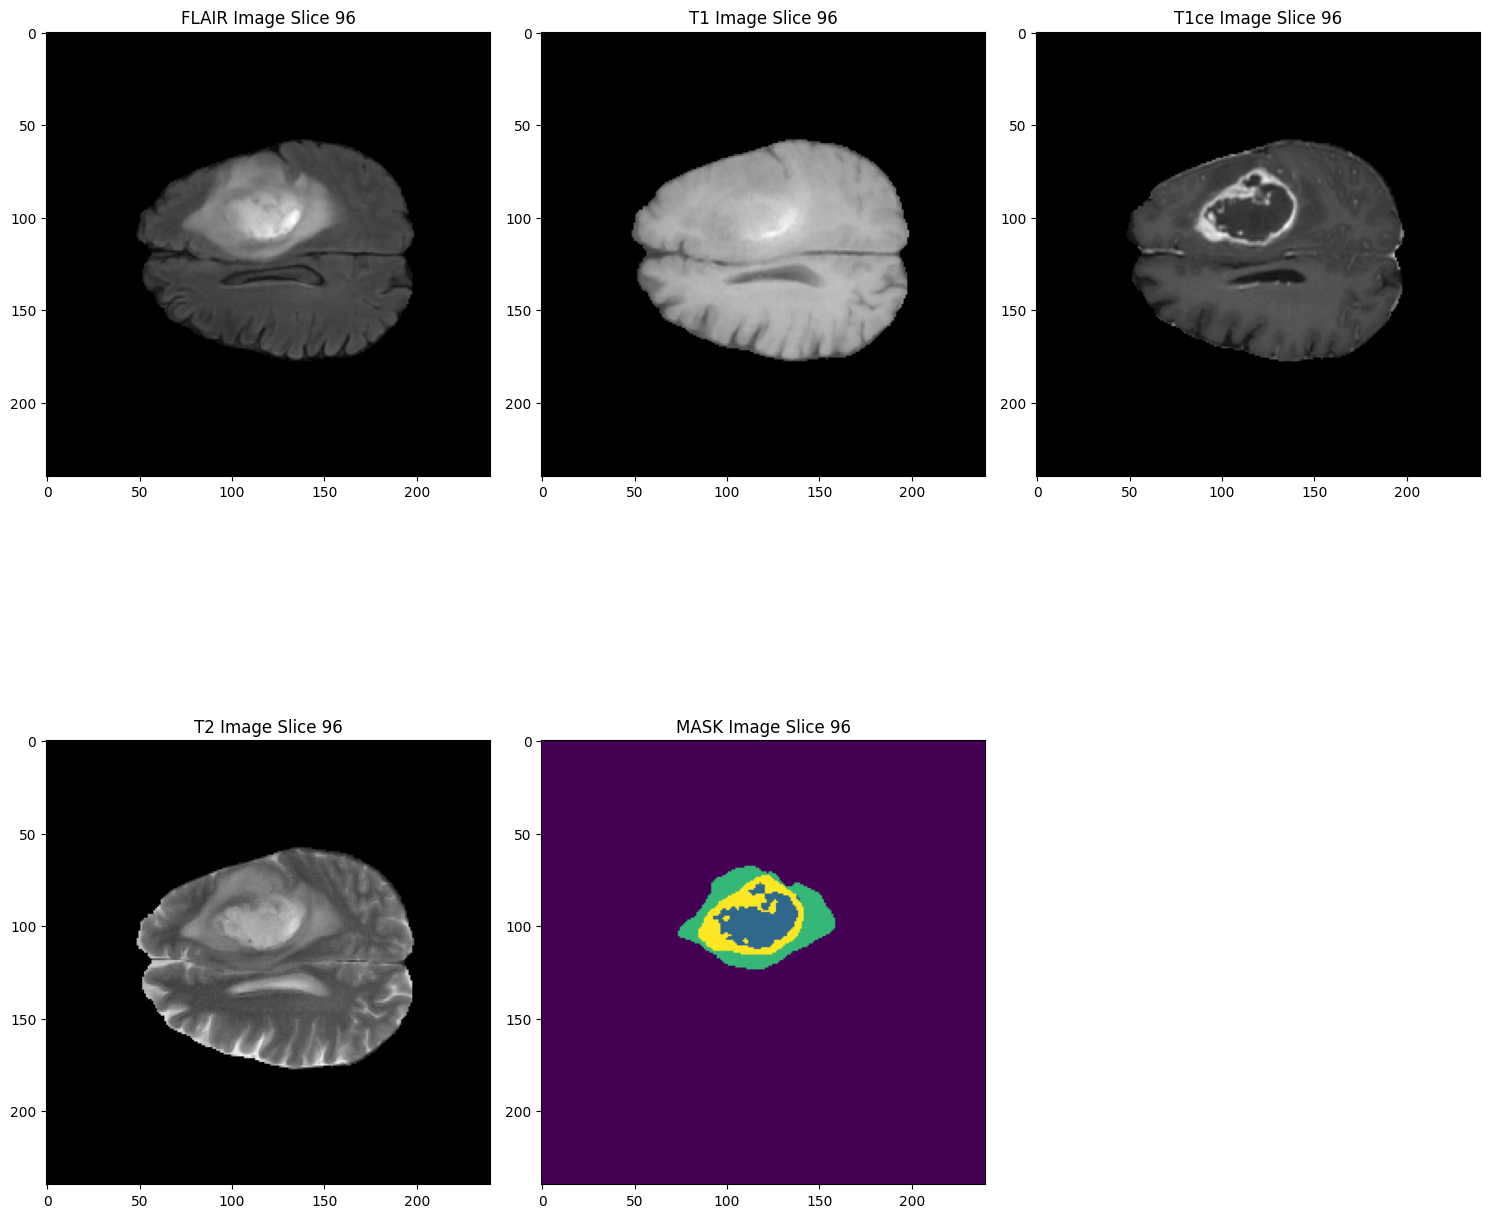

In [18]:
import random 
#
n_slice = random.randint(0,test_mask.shape[2]-1)
# the the maximum slices that can be is 155 
print(n_slice)

plt.figure(figsize=(15, 15))

# FLAIR Image
plt.subplot(231)  # 2 rows, 3 columns, 1st position
plt.imshow(test_image_flair[:, :, n_slice], cmap="gray")
plt.title(f"FLAIR Image Slice {n_slice}")

# T1 Image
plt.subplot(232)  # 2nd position
plt.imshow(test_image_t1[:, :, n_slice], cmap="gray")
plt.title(f"T1 Image Slice {n_slice}")

# T1ce Image
plt.subplot(233)  # 3rd position
plt.imshow(test_image_t1ce[:, :, n_slice], cmap="gray")
plt.title(f"T1ce Image Slice {n_slice}")

# T2 Image
plt.subplot(234)  # 4th position
plt.imshow(test_image_t2[:, :, n_slice], cmap="gray")
plt.title(f"T2 Image Slice {n_slice}")

# MASK Image
plt.subplot(235)  # 5th position
plt.imshow(test_mask[:, :, n_slice])

# why not cmap = 'gray' ??
# beacause we need to show the all the 4 labels in the masked images....
# purple shows label 0
# green shows label 1
# yellow shows label 2
# dark blue shows label 3

plt.title(f"MASK Image Slice {n_slice}")

plt.tight_layout()  # Adjust spacing
plt.show()

# **Now we need to stack the flair , t1ce and t1 nifti togehter**

but why to stack it ?? 
whats need of stacking ?? 

since all these 3 files ( volumes ) are correlated with other bcz of diffeerent intensities they have with the image we can detect the tumor or differentiate it with other pixel part ......

now when if stack ( or we can say combine , not really combine but in a layman manner we can say ) on top of each other , we can examine these 3 volumes together

In [19]:
combined_x = np.stack([test_image_flair ,test_image_t1ce ,test_image_t2 ,test_image_t1 ] , axis=3 )
combined_x.shape
# (240, 240, 155, 4) 4 represent these 4 volumes or 4 channels at index 3....

(240, 240, 155, 4)

# **Convert the test mask to categorical value using one-hot encoding**

In [20]:
test_mask = nn.functional.one_hot(torch.tensor(test_mask, dtype=torch.long), num_classes=4)
test_mask.shape , test_mask

# it converts the labels value of test mask into one-hot encoded vector


(torch.Size([240, 240, 155, 4]),
 tensor([[[[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0]],
 
          [[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0]],
 
          [[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0]],
 
          ...,
 
          [[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0]],
 
          [[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0]],
 
          [[1, 0, 0, 0],
           [1, 0, 0, 0],
           [1, 0, 0, 0],
           ...,
           [1,

# **Now crop the images**

But why to crop the images ???
Why cant we just use them right away ??

because most of the part of the image contains the LABEL 0 area , which isnt helping the determing the TUMOR AREA or OTHER LABELS and is making the computation more long and expensive......so we need to crop it....

**NOTE :** `THE VALUE SHOULD BE DETERMINED BY EXPERIMENTATIONS , THE VALUE WHICH SUITS THE MODEL AND GIVES BEST RESULTS`

In [21]:
combined_x = combined_x[56:184 , 56:184, 13:141]
test_mask = test_mask[56:184 , 56:184, 13:141]


# to make it 128 X 128 X 128 

In [22]:
# combined_x.shape , test_mask.shape

# Replot the STACKED then CROPPED images.....

42
torch.Size([128, 128])


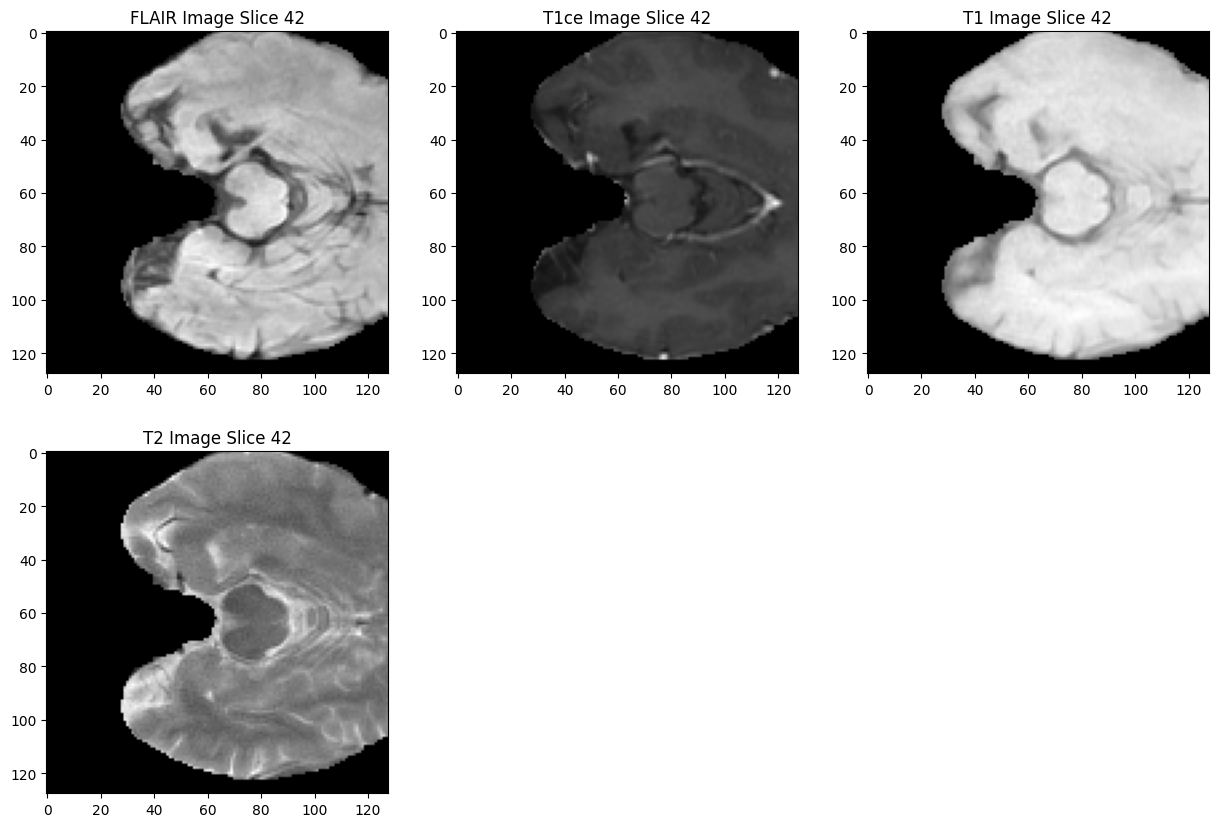

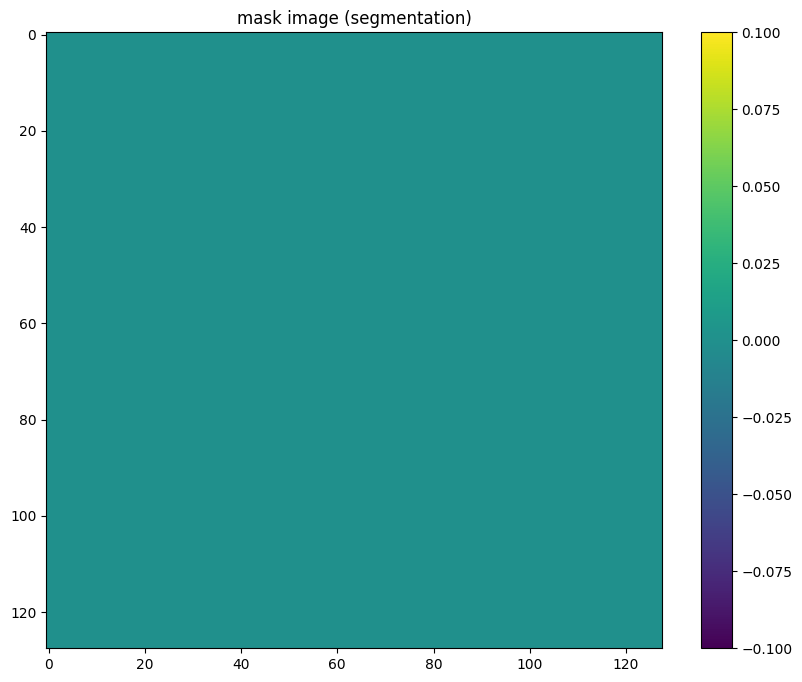

In [23]:
n_slice = random.randint(0,test_mask.shape[2]-1)
# the the maximum slices that can be is 155 
print(n_slice)

plt.figure(figsize=(15, 10))

# FLAIR Image
plt.subplot(231)  # 2 rows, 3 columns, 1st position
plt.imshow(combined_x[:, :,n_slice , 0], cmap="gray")
plt.title(f"FLAIR Image Slice {n_slice}")

# T1ce Image
plt.subplot(232)  # 2nd position
plt.imshow(combined_x[:, :, n_slice ,1], cmap="gray")
plt.title(f"T1ce Image Slice {n_slice}")

# T2 Image
plt.subplot(234)  # 3rh position
plt.imshow(combined_x[:, :,n_slice , 2], cmap="gray")
plt.title(f"T2 Image Slice {n_slice}")

plt.subplot(233)  # 4th position
plt.imshow(combined_x[:, :,n_slice , 3], cmap="gray")
plt.title(f"T1 Image Slice {n_slice}")


plt.figure(figsize=(10,8))

mask_display = torch.argmax(test_mask[:,:,n_slice], dim=-1)
print(mask_display.shape)
# but why to use argmax ??
# since the test_mask category is converted into one-hot encoding , we need argmax to find the labels.
# the torch.argmax(..., dim=-1) selects the channel with the highest value for each pixel, converting it into a single-channel mask (shape (H, W)).
#This allows plt.imshow() to properly display the segmentation.

plt.imshow(mask_display)

plt.colorbar()
plt.title('mask image (segmentation)')
plt.show()

# we can see the images are quite enlarged 
# some files may be bad bcz of wrong crop , so its about experimentation



Label mask:
 [[0 1 2]
 [1 0 1]
 [2 1 0]]


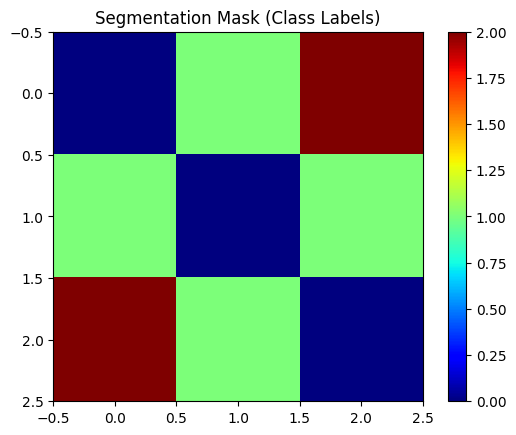

In [24]:
# # simple one-hot encoding example

one_hot_mask = np.array([
    [[1, 0, 0], [0, 1, 0], [0, 0, 1]],
    [[0, 1, 0], [1, 0, 0], [0, 1, 0]],
    [[0, 0, 1], [0, 1, 0], [1, 0, 0]]
])  # Shape (3, 3, 3)

label_mask = np.argmax(one_hot_mask, axis=-1)
print("Label mask:\n", label_mask)

# it gives 

# Label mask:
#  [[0 1 2]
#   [1 0 1]
#   [2 1 0]]

plt.imshow(label_mask, cmap="jet")  # 'jet' shows different colors for classes
plt.colorbar()
plt.title("Segmentation Mask (Class Labels)")
plt.show()

We can save it as Tif File to represent it much better

In [25]:
# from tifffile import imwrite # use it to save multichannel file

# imwrite('Brats_trainingTifffile/combined355.tif' , combined_x)

# np.save('Brats_trainingTifffile/combined355.npy' , combined_x) 
# # we saving it as numpy array too 

In [26]:
# my_img  = np.load('Brats_trainingTifffile/combined355.npy')

In [27]:
# test_mask.shape

In [28]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from glob import glob
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset

class BraTSDataLoader(Dataset):
    
    def __init__(self, path, transform=None, scaler=MinMaxScaler(), device="cpu",a=0,b=None):
        self.path = path
        self.device = device  # Store device information
        self.a = a
        self.b=b
        
        # Load file paths
        self.flair = sorted(glob(self.path + '/*/*flair.nii'))[self.a : self.b]
        self.t1 = sorted(glob(self.path + '/*/*t1.nii'))[self.a : self.b]
        self.t1ce = sorted(glob(self.path + '/*/*t1ce.nii'))[self.a : self.b]
        self.t2 = sorted(glob(self.path + '/*/*t2.nii'))[self.a : self.b]
        self.mask = sorted(glob(self.path + '/*/*seg.nii'))[self.a : self.b]
    
        self.scaler = scaler
        self.transform = transform
        
        print(len(self.t1))
        print(len(self.t1))
        print(len(self.t1ce))
        print(len(self.flair))
        print(len(self.mask))

        
        # Ensure all modalities have the same length
        assert len(self.t1) == len(self.t2) == len(self.t1ce) == len(self.flair) == len(self.mask)

    def __len__(self):
        return len(self.t1)  # Length of dataset
    
    def __getitem__(self, idx):
        # Load images
        temp_flair = nib.load(self.flair[idx]).get_fdata()
        temp_t1 = nib.load(self.t1[idx]).get_fdata()
        temp_t1ce = nib.load(self.t1ce[idx]).get_fdata()
        temp_t2 = nib.load(self.t2[idx]).get_fdata()
        temp_mask = nib.load(self.mask[idx]).get_fdata().astype(np.uint8)

        # Normalize images
        temp_flair = self.scaler.fit_transform(temp_flair.reshape(-1, 1)).reshape(temp_flair.shape)
        temp_t1 = self.scaler.fit_transform(temp_t1.reshape(-1, 1)).reshape(temp_t1.shape)
        temp_t1ce = self.scaler.fit_transform(temp_t1ce.reshape(-1, 1)).reshape(temp_t1ce.shape)
        temp_t2 = self.scaler.fit_transform(temp_t2.reshape(-1, 1)).reshape(temp_t2.shape)
        
        # Fix mask labels by replacing 4 with 3
        print(np.unique(temp_mask))
        temp_mask[temp_mask == 4] = 3
        print(np.unique(temp_mask))
        
        # Stack image modalities (H, W, D, C)
        temp_combined_x = np.stack([temp_flair, temp_t1, temp_t1ce, temp_t2], axis=3)  # (H, W, D, C)

        # One-hot encode mask
        temp_mask = torch.tensor(temp_mask, dtype=torch.long, device=self.device)
        temp_mask = nn.functional.one_hot(temp_mask, num_classes=4).permute(3, 0, 1, 2)  # (C, H, W, D)

        # Crop images and masks to 128x128x128
        temp_combined_x = temp_combined_x[60:188, 60:188, 20:148]  # (128, 128, 128, 4)
        temp_mask = temp_mask[:, 60:188, 60:188, 20:148]  # (4, 128, 128, 128)
        
        # Convert to PyTorch tensors and send to device
        temp_combined_x = torch.tensor(temp_combined_x, dtype=torch.float, device=self.device).permute(3, 0, 1, 2)  # (4, 128, 128, 128)

        if self.transform:
            temp_combined_x = self.transform(temp_combined_x)
            temp_mask = self.transform(temp_mask)

        return temp_combined_x, temp_mask


In [29]:
train_path = r'G:\BraTS\MICCAI_BraTS2020_TrainingData'

BraTSdataTrain = BraTSDataLoader(train_path,a=00,b=300,device=device)

300
300
300
300
300


In [30]:
for i, j in BraTSdataTrain:
    print(f"Train Input shape: {i.shape}")
    print(f"Train Label shape: {j.shape}")
    break
print(f" Data train : {len(BraTSdataTrain)}")
# its also can be called as len(BraTSDataLoader(train_path)) bcz its DUNDER call.....



[0 1 2 4]
[0 1 2 3]
Train Input shape: torch.Size([4, 128, 128, 128])
Train Label shape: torch.Size([4, 128, 128, 128])
 Data train : 300


In [31]:
train_size = int(0.8 * len(BraTSdataTrain))  # %80 train
val_size = int(0.10 * len(BraTSdataTrain))  # %10 validation
test_size = len(BraTSdataTrain) - train_size - val_size

In [32]:
from torch.utils.data import DataLoader, random_split

train_dataset, val_dataset, test_dataset = random_split(
    BraTSdataTrain, 
    [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)  # Set seed for reproducibility
)

In [33]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

In [34]:
for i, j in test_loader:
    print(f"Train Input shape: {i.shape}")
    print(f"Train Label shape: {j.shape}")
    break
print(f"train Data with batch = 2 : {len(BraTSdataTrain)}")

[0 1 2 4]
[0 1 2 3]
[0 1 2 4]
[0 1 2 3]
Train Input shape: torch.Size([2, 4, 128, 128, 128])
Train Label shape: torch.Size([2, 4, 128, 128, 128])
train Data with batch = 2 : 300


[0 1 2 4]
[0 1 2 3]
[0 1 2 4]
[0 1 2 3]
Batch Data Shape: torch.Size([2, 4, 128, 128, 128])
Batch Labels Shape: torch.Size([2, 4, 128, 128, 128])
Sample Data Shape: torch.Size([4, 128, 128, 128])
Sample Label Shape: torch.Size([4, 128, 128, 128])


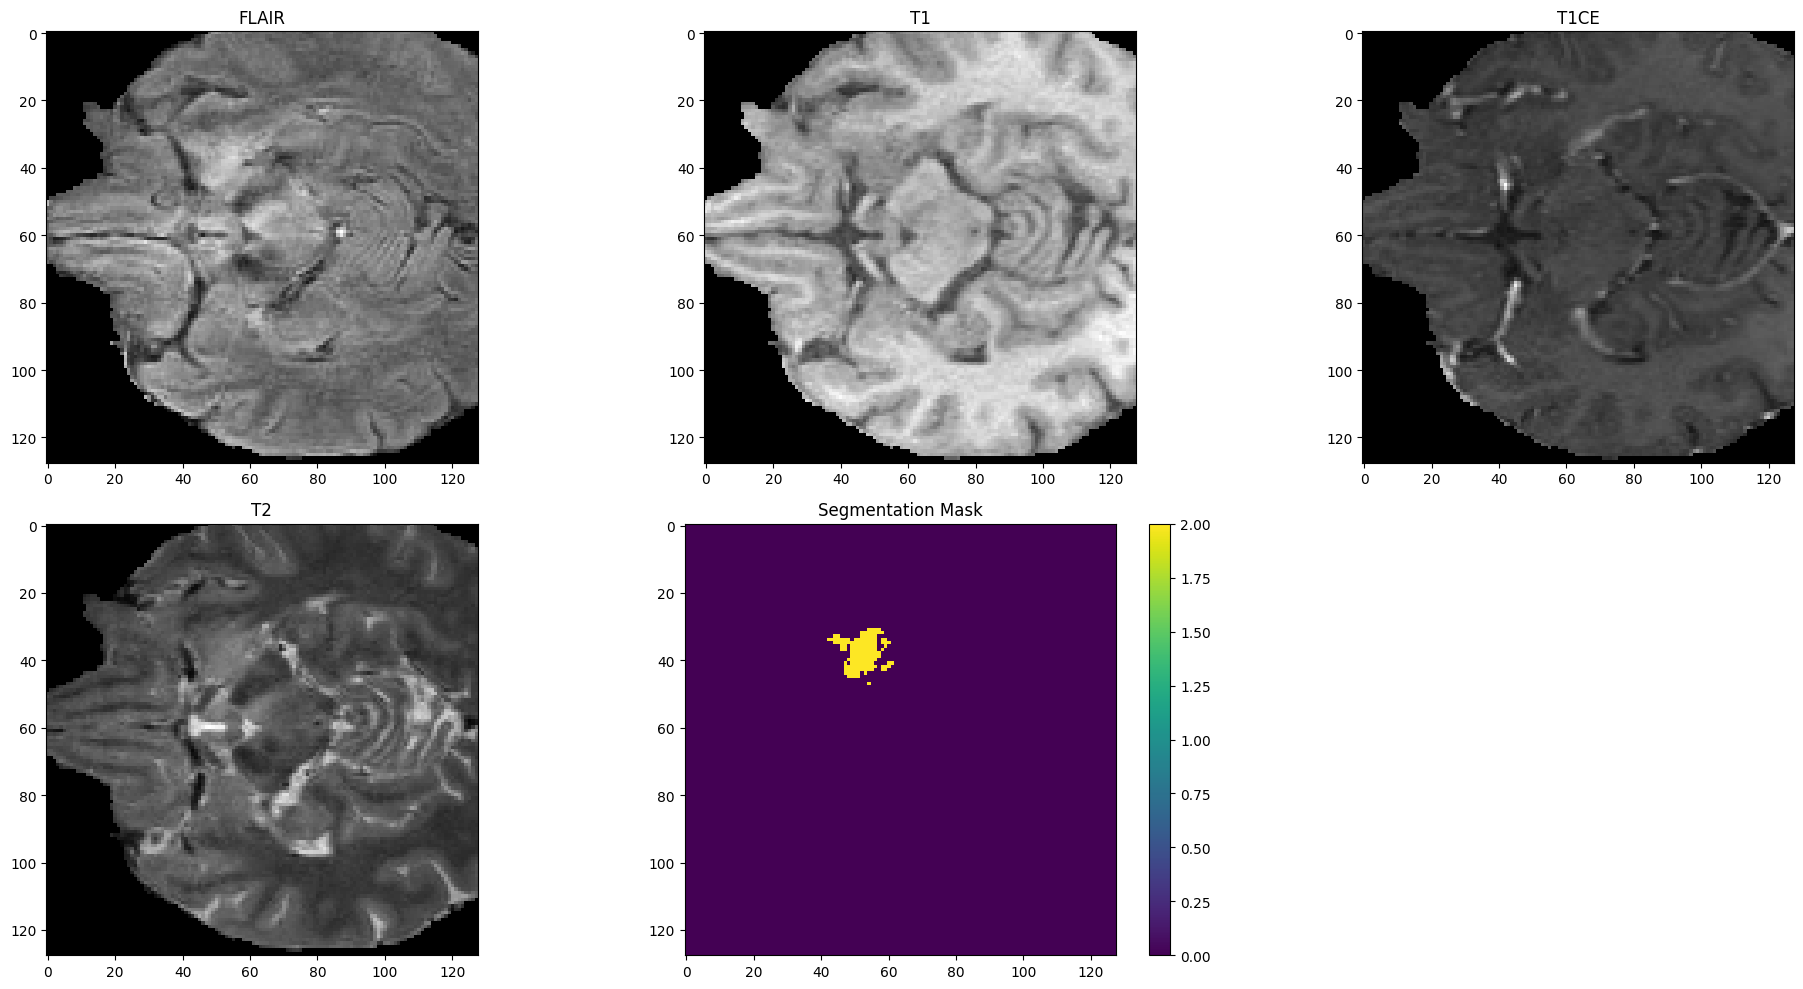

Selected Slice Index: 38
Unique Values in Segmentation Mask: [0 2]


In [35]:
# Load a batch from the DataLoader
for batch_data, batch_labels in train_loader:
    batch_data = batch_data.to(device)  # Move input data to GPU/CPU
    batch_labels = batch_labels.to(device)  # Move labels to GPU/CPU
    
    print(f"Batch Data Shape: {batch_data.shape}")  # Expected: [batch_size, 4, 128, 128, 128]
    print(f"Batch Labels Shape: {batch_labels.shape}")  # Expected: [batch_size, 128, 128, 128, 4]
    break  # Just check the first batch

# Select the first sample
a, b = batch_data[0], batch_labels[0]  # Shape: (4, 128, 128, 128) and (128, 128, 128, 4)

print(f"Sample Data Shape: {a.shape}")  # [4, 128, 128, 128]
print(f"Sample Label Shape: {b.shape}")  # [128, 128, 128, 4]

# Select a random slice
n_slice = random.randint(0, b.shape[2] - 1)  # Select along the depth axis

# Visualization
plt.figure(figsize=(20, 10))

# Display the four MRI modalities
plt.subplot(231)
plt.imshow(a[0, :, :, n_slice].cpu().numpy(), cmap='gray')  # FLAIR
plt.title("FLAIR")

plt.subplot(232)
plt.imshow(a[1, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1
plt.title("T1")

plt.subplot(233)
plt.imshow(a[2, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1CE
plt.title("T1CE")

plt.subplot(234)
plt.imshow(a[3, :, :, n_slice].cpu().numpy(), cmap='gray')  # T2
plt.title("T2")

plt.subplot(235)
# Convert one-hot encoded mask back to categorical values
mask_display = torch.argmax(b, dim=0).cpu().numpy()[:, :, n_slice]
plt.imshow(mask_display, cmap='viridis')  # Use a proper colormap
plt.colorbar()
plt.title("Segmentation Mask")


plt.tight_layout()
plt.show()

print(f"Selected Slice Index: {n_slice}")
print(f"Unique Values in Segmentation Mask: {np.unique(mask_display)}")


In [36]:
print(f"Mask Shape: {b.shape}")  # Expected: [128, 128, 128, 4]
print(f"Unique Values in Mask: {np.unique(torch.argmax(b, dim=0).cpu().numpy())}")



Mask Shape: torch.Size([4, 128, 128, 128])
Unique Values in Mask: [0 1 2 3]


In [37]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

class UNetEncoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetEncoder, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.pool = nn.MaxPool3d(2, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        skip = x 
        x = self.pool(x)
        return x, skip


class UNetDecoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetDecoder, self).__init__()
        self.upconv = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = nn.Conv3d(out_channels * 2, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        return x 


class UNetBottleneck(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNetBottleneck, self).__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)
        self.dropout = nn.Dropout3d(0.3)  # %30 dropout

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.dropout(x)
        return x 


class UnetModel(nn.Module):
    def __init__(self, num_classes):
        super(UnetModel, self).__init__()

        self.encoder1 = UNetEncoder(4, 32)    
        self.encoder2 = UNetEncoder(32, 64)   
        self.encoder3 = UNetEncoder(64, 128)  
        self.encoder4 = UNetEncoder(128, 256) 

        self.bottleneck = UNetBottleneck(256, 512) 

        self.decoder1 = UNetDecoder(512, 256)
        self.decoder2 = UNetDecoder(256, 128)
        self.decoder3 = UNetDecoder(128, 64)
        self.decoder4 = UNetDecoder(64, 32)

        self.final_conv = nn.Conv3d(32, num_classes, kernel_size=1)
    
    def forward(self, x):
        x, skip1 = self.encoder1(x)
        x, skip2 = self.encoder2(x)
        x, skip3 = self.encoder3(x)
        x, skip4 = self.encoder4(x) 

        x = self.bottleneck(x)

        x = self.decoder1(x, skip4)
        x = self.decoder2(x, skip3)
        x = self.decoder3(x, skip2)
        x = self.decoder4(x, skip1)
        
        x = self.final_conv(x)  
        return x 


In [38]:
model = UnetModel(4).to(device)

In [39]:
model


UnetModel(
  (encoder1): UNetEncoder(
    (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder2): UNetEncoder(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (pool): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (encoder3): UNetEncoder(
    (conv1)

In [40]:
class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5, smooth=1e-6):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.smooth = smooth

    def dice_loss(self, pred, target):
        pred = torch.softmax(pred, dim=1)
        intersection = (pred * target).sum(dim=(2, 3, 4))
        union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

    def forward(self, pred, target):
        dice = self.dice_loss(pred, target)
        ce = nn.CrossEntropyLoss()(pred, target.argmax(dim=1))  # [B, 128, 128, 128]
        return self.alpha * dice + (1 - self.alpha) * ce

In [41]:
import os
import time
import torch
import torch.nn as nn
from tqdm import tqdm
 
# Dice Score function
def dice_score(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)  # [B, 4, 128, 128, 128]
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def model_train(model, val_data, train_data, epochs, checkpoint_path="Brain_tumor/tumor_unet_model_v2.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

    if torch.cuda.device_count() > 1:
        print("Using DataParallel for multi-GPU!")
        model = nn.DataParallel(model)
    model.to(device)

    criterion = CombinedLoss()  # Assuming CombinedLoss is defined somewhere
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5)

    # **Load previous checkpoint if available**
    best_dice = 0.0
    if os.path.exists(checkpoint_path):
        print(f"Loading previous checkpoint from {checkpoint_path}...")
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
        print("Checkpoint loaded successfully!")

    best_val_loss = float('inf')
    patience = 5  # Early stopping
    patience_counter = 0

    for epoch in range(epochs):
        start_time = time.time()

        # **Training Phase**
        model.train()
        train_loss = 0
        train_loader = tqdm(train_data, desc=f"Epoch {epoch+1}/{epochs} [Train]")

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)  # [B, 4, 128, 128, 128]
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_loader.set_postfix({'train_loss': train_loss / (train_loader.n + 1)})

        avg_train_loss = train_loss / len(train_data)

        # **Validation Phase**
        model.eval()
        val_loss = 0
        val_dice = 0
        val_loader = tqdm(val_data, desc=f"Epoch {epoch+1}/{epochs} [Val]")

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_dice += dice_score(outputs, labels).item()

                val_loader.set_postfix({'val_loss': val_loss / (val_loader.n + 1),
                                        'val_dice': val_dice / (val_loader.n + 1)})

        avg_val_loss = val_loss / len(val_data)
        avg_val_dice = val_dice / len(val_data)

        scheduler.step(avg_val_loss)

        epoch_duration = time.time() - start_time

        print(f'Epoch {epoch+1}/{epochs}')
        print(f'Training Loss: {avg_train_loss:.4f}')
        print(f'Validation Loss: {avg_val_loss:.4f}')
        print(f'Validation Dice: {avg_val_dice:.4f}')
        print(f'Time Taken: {epoch_duration:.2f} seconds')
        print('-' * 50)

        # **Save the best model based on Dice Score**
        if avg_val_dice > best_dice:
            best_dice = avg_val_dice
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), checkpoint_path)
            print(f"Best model saved with Dice: {best_dice:.4f}, Val Loss: {best_val_loss:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

            model_path = "Brain_tumor/unet_model_v1.pth"

            # Save model parameters
            torch.save(model.state_dict(), model_path)



In [42]:
print(next(model.parameters()).device)


cpu


In [43]:
print(next(model.parameters()).device)  # Should print cuda:0


cpu


In [44]:
# model_train(model, val_loader, train_loader, epochs=10,checkpoint_path="Brain_tumor/tumor_unet_model_v4.pth")

In [45]:
import torch

# Define file path to save the model
model_path = "Brain_tumor/tumor_unet_model_v5.pth"

# Save model parameters
torch.save(model.state_dict(), model_path)

print(f"Model parameters saved to {model_path}")

Model parameters saved to Brain_tumor/tumor_unet_model_v5.pth


In [46]:
torch.cuda.empty_cache()

In [47]:
!nvidia-smi

NVIDIA-SMI has failed because you do not have suffient permissions. Please try running as an administrator.


In [48]:
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = UnetModel(4)  # Replace with your model class\\
checkpoint_path = r"D:\web dev backup\Pytorch\Brain_tumor\tumor_unet_model_v20.pth"
# model.load_state_dict(torch.load(r"D:\web dev backup\Pytorch\Brain_tumor\unet_model_v5.pth"))

if os.path.exists(checkpoint_path):
      print(f"Loading previous checkpoint from {checkpoint_path}...")
      checkpoint = torch.load(checkpoint_path, map_location=device)

    #   if 'best_dice' in checkpoint and checkpoint['best_dice'] is not None:
    #       best_dice = checkpoint['best_dice']
    #       print(f"Loaded best Dice score from checkpoint: {best_dice:.4f}")
    #   else:
    #       best_dice = 0.0
    #       print("No best Dice score found in checkpoint. Using default value of 0.0.")

      model.load_state_dict(checkpoint)
    #   model.load_state_dict(checkpoint_path)  
      print("Checkpoint loaded successfully!")
else:
      print("No checkpoint found. Starting training from scratch.")
      
model.to(device)
model.eval()
print("Model loaded successfully!")

Loading previous checkpoint from D:\web dev backup\Pytorch\Brain_tumor\tumor_unet_model_v20.pth...
Checkpoint loaded successfully!
Model loaded successfully!


In [80]:
data = natsorted(glob(os.path.join(r"G:\BraTS\MICCAI_BraTS2020_TestingData", "*", "*_t1ce.nii")))
dataseg = natsorted(glob(os.path.join(r"G:\BraTS\MICCAI_BraTS2020_TestingData", "*", "*_seg.nii")))
data = data+dataseg
data

['G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_355\\BraTS20_Training_355_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_356\\BraTS20_Training_356_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_357\\BraTS20_Training_357_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_358\\BraTS20_Training_358_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_359\\BraTS20_Training_359_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_360\\BraTS20_Training_360_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_361\\BraTS20_Training_361_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_362\\BraTS20_Training_362_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_363\\BraTS20_Training_363_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_TestingData\\BraTS20_Training_364\\BraTS20_Training_364_t1ce.nii',
 'G:\\BraTS\\MICCAI_BraTS2020_

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import nibabel as nib
from torch.utils.data import Dataset
from sklearn.preprocessing import MinMaxScaler

class TestDataLoader(Dataset):
    
    def __init__(self, data, transform=None, scaler=MinMaxScaler(), device=device ):
        self.device = device
        self.scaler = scaler
        self.transform = transform
        
        # Split the data list into t1ce and mask lists
        self.t1ce = [path for path in data if "_t1ce.nii" in path]
        self.mask = [path for path in data if "_seg.nii" in path]
        
        # Ensure both lists are sorted and of equal length
        self.t1ce = sorted(self.t1ce)
        self.mask = sorted(self.mask)

        # Check data consistency
        assert len(self.t1ce) == len(self.mask), "Mismatch between t1ce and mask files"
        
        print(f"Loaded {len(self.t1ce)} t1ce files and {len(self.mask)} masks")

    def __len__(self):
        return len(self.t1ce)
    
    def __getitem__(self, idx):
        # Load t1ce and mask files
        temp_t1ce = nib.load(self.t1ce[idx]).get_fdata()
        temp_mask = nib.load(self.mask[idx]).get_fdata().astype(np.uint8)
        
        # Normalize the t1ce image
        temp_t1ce = self.scaler.fit_transform(temp_t1ce.reshape(-1, 1)).reshape(temp_t1ce.shape)
        
        # Fix mask labels by replacing 4 with 3
        temp_mask[temp_mask == 4] = 3
        
        # Convert to tensors and move to the specified device
        temp_t1ce = torch.tensor(temp_t1ce, dtype=torch.float32, device=self.device).unsqueeze(0)  # (1, H, W, D)
        temp_mask = torch.tensor(temp_mask, dtype=torch.long, device=self.device)

        # One-hot encode the mask
        temp_mask = nn.functional.one_hot(temp_mask, num_classes=4).permute(3, 0, 1, 2)  # (C, H, W, D)
        
        # Apply optional transformations
        if self.transform:
            temp_t1ce = self.transform(temp_t1ce)
            temp_mask = self.transform(temp_mask)

        return temp_t1ce, temp_mask


In [85]:

test_dataset = TestDataLoader(data ,device=device)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


Loaded 15 t1ce files and 15 masks


In [ ]:
# # Load a batch from the DataLoader
# for batch_data, batch_labels in test_loader:
#     batch_data = batch_data.to(device)  # Move input data to GPU/CPU
#     batch_labels = batch_labels.to(device)  # Move labels to GPU/CPU
    
#     print(f"Batch Data Shape: {batch_data.shape}")  # Expected: [batch_size, 4, 128, 128, 128]
#     print(f"Batch Labels Shape: {batch_labels.shape}")  # Expected: [batch_size, 128, 128, 128, 4]
#     break  # Just check the first batch

# # Select the first sample
# a, b = batch_data[0], batch_labels[0]  # Shape: (4, 128, 128, 128) and (128, 128, 128, 4)

# print(f"Sample Data Shape: {a.shape}")  # [4, 128, 128, 128]
# print(f"Sample Label Shape: {b.shape}")  # [128, 128, 128, 4]

# # Select a random slice
# # n_slice = random.randint(0, b.shape[2] - 1)  # Select along the depth axis
# n_slice = 64


# # Visualization
# plt.figure(figsize=(6, 6))

# # Display the four MRI modalities
# plt.subplot(231)
# plt.imshow(a[0, :, :, n_slice].cpu().numpy(), cmap='gray')  # FLAIR
# plt.title("FLAIR")

# plt.subplot(232)
# plt.imshow(a[1, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1
# plt.title("T1")

# plt.subplot(233)
# plt.imshow(a[2, :, :, n_slice].cpu().numpy(), cmap='gray')  # T1CE
# plt.title("T1CE")

# plt.subplot(234)
# plt.imshow(a[3, :, :, n_slice].cpu().numpy(), cmap='gray')  # T2
# plt.title("T2")

# plt.subplot(235)
# # Convert one-hot encoded mask back to categorical values
# mask_display = torch.argmax(b, dim=0).cpu().numpy()[:, :, n_slice]
# plt.imshow(mask_display, cmap='viridis')  # Use a proper colormap
# plt.colorbar()
# plt.title("Segmentation Mask")


# plt.tight_layout()
# plt.show()

# print(f"Selected Slice Index: {n_slice}")
# print(f"Unique Values in Segmentation Mask: {np.unique(mask_display)}")

ValueError: not enough values to unpack (expected 2, got 1)

In [86]:
import numpy as np
import matplotlib.pyplot as plt

def dice_coefficient(pred, target, smooth=1e-6):
    pred = torch.softmax(pred, dim=1)  # [B, 4, 128, 128, 128]
    intersection = (pred * target).sum(dim=(2, 3, 4))
    union = pred.sum(dim=(2, 3, 4)) + target.sum(dim=(2, 3, 4))
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean()

def visualize_prediction(image, mask, prediction):
    # print("Image shape:", image.shape)
    print("Mask shape:", mask.shape)
    print(mask.max())
    # # print("Prediction shape:", prediction.shape)
    # mask = nib.load(mask).get_fdata().astype(np.uint8)
    
    # mask = mask[mask == 4] = 3
    
    plt.figure(figsize=(12, 4))

    # Visualizing one of the channels (e.g., FLAIR)
    for i in range(60,72,3):
        flair_slice = image[0, 0, :, :, i].cpu().numpy()  # Taking a middle slice from FLAIR channel
        mask_slice = mask[0, 0, :, :, i].cpu().numpy()    # Middle slice of ground truth mask
        pred_slice = prediction[0, :, :, i]               # Middle slice of predicted mask
        
        # 
        
        

        plt.subplot(1, 3, 1)
        plt.imshow(flair_slice, cmap='gray')  # Display FLAIR channel
        plt.title("FLAIR")

        plt.subplot(1, 3, 2)
        plt.imshow(mask_slice, cmap='viridis')
        plt.colormaps()
        plt.colorbar()
        plt.title("Ground Truth")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_slice, cmap='viridis')
        plt.colormaps()
        plt.colorbar()
        plt.title("Prediction")

        plt.show()






In [53]:
# def visualize_prediction(image, mask):
    
#     # Load a batch from the DataLoader
#      # Just check the first batch

#     # print("Image shape:", image.shape)
#     print("Mask shape:", mask.shape)
#     print(mask.max())
#     # # print("Prediction shape:", prediction.shape)
#     # mask = nib.load(mask).get_fdata().astype(np.uint8)
    
#     # mask = mask[mask == 4] = 3
    
#     plt.figure(figsize=(8, 8))

#     # Visualizing one of the channels (e.g., FLAIR)
#     for i in range(50,112,1):
#         # flair_slice = image[0, 0, :, :, i].cpu().numpy()  # Taking a middle slice from FLAIR channel
#         # mask_slice = mask[0, 0, :, :, i].cpu().numpy()    # Middle slice of ground truth mask
        

#         # plt.subplot(1, 3, 1)
#         # plt.imshow(flair_slice, cmap='gray')  # Display FLAIR channel
#         # plt.title("FLAIR")
#         mask_display = torch.argmax(mask, dim=1).cpu().numpy()[0, :, :, i]
#         plt.subplot(1, 3, 2)
#         plt.imshow(mask_display, cmap='viridis')
#         plt.colormaps()
#         plt.colorbar()
#         plt.title("Ground Truth")


#         plt.show()


In [54]:
# with torch.no_grad():
    
    
#     for batch_idx, (image, mask) in enumerate(test_loader):
#         image = image.to(device)
#         mask = mask.to(device)
              
#         # print(np.unique(mask).cpu)
#         # plt.imshow(mask.cpu().numpy()[0,0,:,:,64])
        
#         # print(image.shape)
#         # print(mask.shape)
        
#         visualize_prediction(image, mask)

In [87]:
model.eval()
total_dice = 0
num_samples = 0

with torch.no_grad():
    for batch_idx, (image, mask) in enumerate(test_loader):
        image = image.to(device)
        mask = mask.to(device)
        
        # print(np.unique(mask).cpu)
        # plt.imshow(mask.cpu().numpy()[0,0,:,:,64])
        
        # print(image.shape)
        # print(mask.shape)

        # Forward pass
        output = model(image)

        # Calculate Dice coefficient
        dice = dice_coefficient(output, mask)
        total_dice += dice
        num_samples += 1

        # Convert predictions to class labels for visualization
        print(output.max())
        predicted_mask = torch.argmax(output, dim=1).cpu().numpy()
        # print(predicted_mask.shape)

        print(f"Sample {batch_idx + 1}: Dice Coefficient = {dice:.4f}")

        # Visualize the result (for first few samples)
        
        visualize_prediction(image, mask, predicted_mask)

print(f"Average Dice Coefficient: {total_dice / num_samples:.4f}")


RuntimeError: Given groups=1, weight of size [32, 4, 3, 3, 3], expected input[1, 1, 240, 240, 155] to have 4 channels, but got 1 channels instead